<a href="https://colab.research.google.com/github/ToM4tto/MovieCompanion/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSD3185 Group 26 Machine Learning Project**: 
## MovieCompanion - A Movie Recommendation System

## Mounting Google Drive

In [1]:
#Load the Drive helper and mount
from google.colab import drive

#This will prompt for authorisation
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data
TMDB 5000 Movies Dataset: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata


*   Make sure you have the datasets in your Google Drive when running this project



In [2]:
import pandas as pd 
import numpy as np 
df1 = pd.read_csv("/content/drive/MyDrive/tmdb_5000_movies.csv")
df2 = pd.read_csv("/content/drive/MyDrive/tmdb_5000_credits.csv")
df2.columns = ['id','title','cast','crew'] #df2 movie_id has to be renamed to id to merge w/ df1

# Merge the two DataFrames on the 'id' column
df1 = df1.merge(df2,on='id')

# Drop the duplicate column 'title_y'
df1 = df1.drop('title_y', axis=1)

# Rename the column 'title_x' to 'title'
df1 = df1.rename(columns={'title_x': 'title'})

#Peek our data
df1.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


## Visualising Data (optional)

In [3]:
import matplotlib.pyplot as plt

#enable graph render inline on Jupyter notebooks
%matplotlib inline 

#Make smaller dataframe with lesser cols
ratings = df1[["title", "vote_average", "vote_count"]]

# Sort the DataFrame by highest vote_score given the highest vote_count
ratings = ratings.sort_values(['vote_count', 'vote_average'], ascending=[False, False])

#Peek at our data
ratings.head(5)

,title,vote_average,vote_count
96,Inception,8.1,13752
65,The Dark Knight,8.2,12002
0,Avatar,7.2,11800
16,The Avengers,7.4,11776
788,Deadpool,7.4,10995


Distribution of Vote_Count (frequency vs vote_count)


<Axes: >

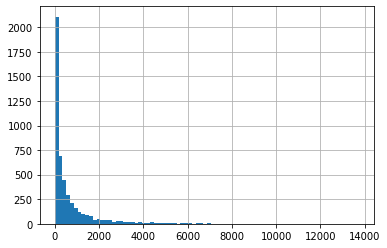

In [4]:
#Print Distribution of vote_count
print("Distribution of Vote_Count (frequency vs vote_count)")
ratings['vote_count'].hist(bins=80)

Distribution of Average Vote (frequency vs vote_average)


<Axes: >

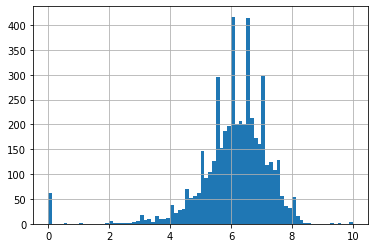

In [5]:
#Print Distribution of Average Votes
print("Distribution of Average Vote (frequency vs vote_average)")
ratings['vote_average'].hist(bins=80)

## **Algorithm 1:** Content-based Filtering

We will be computing scores for all movies based on different features (Overview, Credits, Genres and Keywords) in order to make good recommendations.

We need to compute the **Term Frequency-Inverse Document Frequency (TF-IDF) vectors**  for each plot overview. The TF-IDF score for a given word in a given document is high if that word appears frequently in that document but infrequently in the other documents. Conversely, the score is low if the word appears frequently in many documents in the corpus. By calculating the TF-IDF score for each word in each document, we can identify the words that are most strongly associated with each document, which can be useful for tasks such as document classification or information retrieval.

We will obtain a **TF-IDF matrix**  where each column represents a word in the combined set of movie overviews and each row represents a movie. Each element would represent the TFIDF score of the word in col for the movie in row. This allows us to filter significant words and therefore their significance to the various movies, helping us in our recommendation.

**Getting plot overview**

In [6]:
#Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each plot overview
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove common english stop words e.g: "the", "a"
tfidf = TfidfVectorizer(stop_words = "english")

#Clean Data by removing NaN empty string
df1["overview"] = df1["overview"].fillna("")

#Construct TF-IDF matrix by fitting and transforming the data (text) into a TF-IDF matrix representation
tfidf_matrix = tfidf.fit_transform(df1["overview"])

#Output the shape of tfidf_matrix
# 20978 different words describe 4803 movies in our data
tfidf_matrix.shape

(4803, 20978)

Calculate the Cosine Similarity: 

In [7]:
#Import linear_kernel (dot product)
from sklearn.metrics.pairwise import cosine_similarity

#Cosine similarity is the dot product between two normalized vectors, the similarity between all pairs of movies in the dataset
#each element (i,j) in the cosine_sim matrix represents the dot product of the ith row of tfidf with the jth row of tfidf,
#this calculates similarity with every other movie (row)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

#Create a mapping between movie titles and their indices in the dataset, dropping duplicate movie titles
title_to_indices = pd.Series(df1.index, df1['title']).drop_duplicates()

In [8]:
# Function that takes in movie title as input and outputs most similar movies
def getRecommendations(title, cosine_sim, top=10):
    # Error checking, invalid movie title
    if (title not in title_to_indices.index):
      print("Movie not in dataset, cannot recommend")
      return
    # Index of the movie that has the title
    index = title_to_indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = cosine_sim[index]

    # Sort movies based on the similarity scores in desc order and return top 10 most similar
    # Gets the array of indices if it were to be sorted
    movie_indices = np.argsort(-sim_scores)[1:top+1]

    # Return the top 10 most similar movies, gets location from df1
    return df1.loc[movie_indices, 'title']


In [9]:
getRecommendations('Iron Man', cosine_sim, 10)

79                     Iron Man 2
31                     Iron Man 3
1868           Cradle 2 the Grave
7         Avengers: Age of Ultron
538                       Hostage
119                 Batman Begins
1290     Baahubali: The Beginning
4574                     Roadside
2044           The Little Vampire
2633    The Clan of the Cave Bear
Name: title, dtype: object

**This code changes dataframe, run this code once!**

In [10]:
# Parse the JSON formatted features into their corresponding python objects
import json

features = ['cast', 'crew', 'keywords', 'genres']
# Iterate over each feature column
for feature in features:
    # Parse the JSON strings into Python objects, a list of dictionaries
    df1[feature] = df1[feature].apply(lambda x: json.loads(x))

# Get Director from "crew" feature lists
def getDirector(crews):
    for crew in crews:
        #if isinstance(crew, dict):
          if crew['job'] == 'Director':
            return crew['name']
    return np.nan

# Returns Top 3 in "cast", "keywords", "genres" feature lists
def getTop3(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if > 3 elements. If no, returns entire list. 
        if len(names) >= 3:
            names = names[:3]
        return names
    #Return empty list in case of missing/malformed data
    return []

features = ['cast', 'keywords', 'genres']
for feature in features:
    df1[feature] = df1[feature].apply(getTop3) # Apply function along an axis of the DataFrame, each object passed to function should be a Series list

# Set director, cast, genres and keywords features in a suitable format.
df1['director'] = df1['crew'].apply(getDirector)

# Print the new features of the first 3 films
df1.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",Gore Verbinski
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",Sam Mendes


In [11]:
#Clean Data by converting ALL strings to lowercase and remove spaces
def clean_data(x):
    if isinstance(x, list):
      return [str.lower(i.replace(" ", "")) for i in x]
    else:
      #Check if Director exists. If not, return empty string
      if isinstance(x, str):
        return str.lower(x.replace(" ", ""))
      else:
        return ""

features = ['cast', 'keywords', 'director', 'genres']
# Apply clean_data function to your features
for feature in features:
  df1[feature] = df1[feature].apply(clean_data)

def collectiveSoup(x):
    return " ".join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df1['soup'] = df1.apply(collectiveSoup, axis=1) #combine the top 3 in 1 string in a new dataframe

CountVectorizer() instead of TF-IDF as we do not want to reduce the significance of an actor/director if they appeared in more movies (TF-IDF would reduce), we just want count of each word in `soup`.
**Changing dataframe, run this code once!**

In [12]:
# Import CountVectorizer and create the count matrix for each unique word in soup
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df1['soup']) #matrix has 1 row per movie and 1 column per unique word in the soup, each element would be the frequency each unique word appeared in soup

#Cosine similarity is the dot product between two normalized vectors (normalised automatically), the similarity between all pairs of movies in the dataset
#each element (i,j) in the cosine_sim2 matrix represents the dot product of the ith row of count_matrix with the jth row of count_matrix,
#this calculates similarity with every other movie (row)
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Combined 'PLOT OVERVIEW' WITH 'cast', 'keywords', 'director', 'genres' similarities
# Normalize the matrices
normalized_cosine_sim1 = cosine_sim / cosine_sim.max()
normalized_cosine_sim2 = cosine_sim2 / cosine_sim2.max()

# Combine the similarity matrices using a weighted sum
alpha = 0.5  # weight for tf-idf matrix
beta = 0.5  # weight for count matrix
combined_sim = alpha * normalized_cosine_sim1 + beta * normalized_cosine_sim2

# Reset index and re-create mapping between movie titles and their indices in the dataset, dropping duplicates was already done
df1 = df1.reset_index()
indices = pd.Series(df1.index, index=df1['title'])

In [13]:
getRecommendations('Iron Man', combined_sim, 15) #get top 15 movies

79                                     Iron Man 2
31                                     Iron Man 3
7                         Avengers: Age of Ultron
39                                   TRON: Legacy
26                     Captain America: Civil War
16                                   The Avengers
4401                          The Helix... Loaded
83                                     The Lovers
2912                                    Star Wars
182                                       Ant-Man
4117                           Six-String Samurai
193                                   After Earth
127                            Mad Max: Fury Road
233     Star Wars: Episode I - The Phantom Menace
205            Sherlock Holmes: A Game of Shadows
Name: title, dtype: object

## **Algorithm 2:** Collaborative Filtering

Currently, our recommender is only able to recommend movies which are close to a certain movie. Different users keying in the same movie will get the exact same recommendations. Now, we want to make it more personal and account for the personal tastes and biases of a user.

We will be using item-item (item-based) collaborative filtering instead of user-user (user-based) as items are simpler than users (more fundamental) and also users' preferences can change over time.

Instead of measuring the similarity (Pearson Correlation or Cosine Similarity)between users, the item-item CF recommends items based on their similarity with other items that the target user rated (we will fill the users vs movies table vertically).

Some issues with item-item method:
1. Scalability - Computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items.
2. Sparsity - In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have a similar rating for the only user who ranked them both.

To minimise this we chose to turn it into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. By using Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

SVD decreases the dimension of a complex matrix by extracting its latent factors/features. Essentially, we map each user and each item into a latent space with dimension r. We will use Surprise library to implement the SVD.

In [26]:
#!pip install scikit-surprise
# !conda install -y -c conda-forge scikit-surprise # If you use conda on a non-Colab environment
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv("/content/drive/MyDrive/ratings_small.csv")
ratings.head()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Define the SVD algorithm
svd = SVD()

# Use cross_validate to evaluate the performance of the algorithm using 5-fold cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)

# Print the results
print("Evaluating RMSE, MAE of algorithm SVD.\n")
for fold_idx, rmse, mae in zip(range(1, 6), results['test_rmse'], results['test_mae']):
    print(f"Fold {fold_idx}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print("------------")
print("------------")
print(f"Mean RMSE: {results['test_rmse'].mean():.4f}") #Should be about 0.89 which is good enough for us
print(f"Mean MAE : {results['test_mae'].mean():.4f}")
print("------------")

trainset = data.build_full_trainset()
svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD.

Fold 1
RMSE: 0.8879
MAE:  0.6821
------------
Fold 2
RMSE: 0.9001
MAE:  0.6954
------------
Fold 3
RMSE: 0.9034
MAE:  0.6934
------------
Fold 4
RMSE: 0.8983
MAE:  0.6923
------------
Fold 5
RMSE: 0.8977
MAE:  0.6895
------------
------------
Mean RMSE: 0.8975
Mean MAE : 0.6905
------------


In [27]:
ratings[ratings['userId'] == 1] #Ratings userId 1 has given

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [137]:
estimate = svd.predict(1, 302, 3).est #For movie with ID 302, we get an estimated prediction of 2.618

# Print the estimate and movie name
print(f"Estimated rating for Movie Id: 302: {estimate}")

Estimated rating for Movie Id: 302: 2.818646186862322
